In [17]:
import numpy as np
from matplotlib import pyplot as plt
import numba
from typing import Any, Callable, Tuple
import pandas as pd

In [2]:
tri_points = [[0,0], [1,0], [0.5, np.sqrt(1-0.5**2)]]
tri_points = np.array(tri_points)

center = np.mean(tri_points, axis=0)

tri_points = tri_points-center

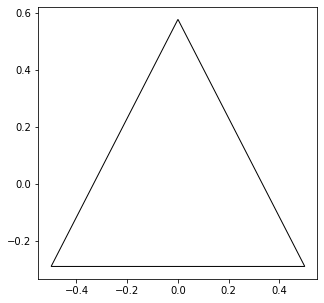

In [3]:
plt.figure(1, figsize=(5,5))

plt.fill(tri_points[:,0], tri_points[:,1], fill=False)

In [141]:
@numba.njit
def sample_points(vertices:np.ndarray, n_point:int) -> np.ndarray:
    points = np.empty((n_point, 2))
    n_vertice = vertices.shape[0]

    for i in range(n_point):
        vertice1_index = np.random.randint(0, n_vertice)
        vertice2_index = vertice1_index + 1

        if vertice2_index == n_vertice:
            vertice2_index = 0

        vertice1 = vertices[vertice1_index]
        vertice2 = vertices[vertice2_index]

        alpha = np.random.rand(1)[0]

        points[i] = alpha * vertice1
        points[i] += (1-alpha) * vertice2
    
    return points

In [163]:
@numba.njit
def cmp_fn(l, r, *arrays):
    for a in numba.literal_unroll(arrays):
        if a[l] < a[r]:
            return -1  # less than
        elif a[l] > a[r]:
            return 1   # greater than

    return 0  # equal

@numba.njit
def quicksort(index, L, R, *arrays):
    l, r = L, R
    pivot = index[(l + r) // 2]

    while True:
        while l < R and cmp_fn(index[l], pivot, *arrays) == -1:
            l += 1
        while r >= L and cmp_fn(pivot, index[r], *arrays) == -1:
            r -= 1

        if l >= r:
            break

        index[l], index[r] = index[r], index[l]
        l += 1
        r -= 1

        if L < r:
            quicksort(index, L, r, *arrays)

        if l < R:
            quicksort(index, l, R, *arrays)

@numba.njit
def lexsort(arrays):

    if len(arrays) == 0:
        return np.empty((), dtype=np.intp)

    if len(arrays) == 1:
        return np.argsort(arrays[0])


    for a in numba.literal_unroll(arrays[1:]):
        if a.shape != arrays[0].shape:
            raise ValueError("lexsort array shapes don't match")

    n = arrays[0].shape[0]
    index = np.arange(n)

    quicksort(index, 0, n - 1, *arrays)
    return index

@numba.njit
def sample_points_sequential(vertices:np.ndarray, n_point:int) -> np.ndarray:
    points = np.empty((n_point, 2))
    n_vertice = vertices.shape[0]

    info = np.empty((n_point,2))

    for i in range(n_point):
        vertice1_index = np.random.randint(0, n_vertice)
        alpha = np.random.rand(1)[0]

        info[i][0] = vertice1_index
        info[i][1] = alpha

    ind = lexsort((info[:,0], info[:,1]))

    info = info[ind]

    for i in range(n_point):
        vertice1_index = int(info[i][0])
        alpha = info[i][1]

        vertice2_index = vertice1_index + 1

        if vertice2_index == n_vertice:
            vertice2_index = 0

        vertice1 = vertices[vertice1_index]
        vertice2 = vertices[vertice2_index]

        points[i] =  (1-alpha) * vertice1
        points[i] += alpha * vertice2
    
    return points

In [190]:
from scipy.spatial.transform import Rotation

@numba.njit
def rotate_points(points:np.ndarray, angle:float) -> np.ndarray:
    angle = np.radians(angle)

    rotation_matrix = np.empty((2,2))
    rotation_matrix[0,0] = np.cos(angle)
    rotation_matrix[0,1] = np.sin(angle)
    rotation_matrix[1,0] = -rotation_matrix[0,0]
    rotation_matrix[1,1] = rotation_matrix[0,0]

    points_r = points @ rotation_matrix

    return points_r


In [136]:
@numba.njit
def add_noise(points, std, add_chance):
    n_points = points.shape[0]

    noise = np.random.normal(0, std, (n_points, 2))

    add_mask_x = np.random.rand(n_points) < add_chance
    add_mask_y = np.random.rand(n_points) < add_chance


    new_points = points.copy()
    new_points[add_mask_x, 0] += noise[add_mask_x, 0]
    new_points[add_mask_y, 1] += noise[add_mask_y, 1]

    return new_points

In [132]:
@numba.njit
def scale_unit(points):
    x_min = points[:,0].min()
    y_min = points[:,1].min()

    x_max = points[:,0].max()
    y_max = points[:,1].max()

    x_range = x_max - x_min
    y_range = y_max - y_min

    if x_range > y_range:
        scale = 1/x_range
    else:
        scale = 1/y_range

    return points.copy()*scale

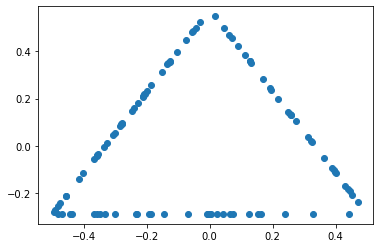

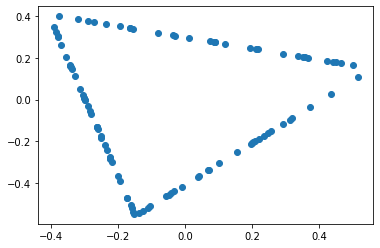

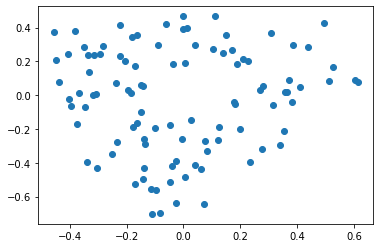

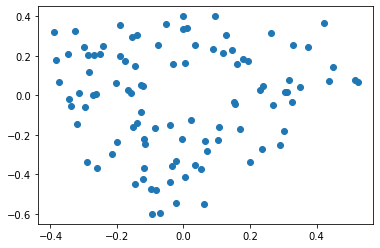

In [191]:
points = sample_points(tri_points, 100)

plt.plot(points[:,0], points[:,1], "o")
plt.show()

points = rotate_points(points, 45)

plt.plot(points[:,0], points[:,1], "o")
plt.show()

points = add_noise(points, 0.1, 1.0)

plt.plot(points[:,0], points[:,1], "o")
plt.show()

points = scale_unit(points)

plt.plot(points[:,0], points[:,1], "o")
plt.show()

In [28]:
#model_function(points, model_points) -> n_inliers, model
def ransac(points, model_function:Callable[[np.ndarray, np.ndarray], Tuple[int, Any]], n, success_rate=0.9, p_inlier=0.8):
    k = np.log10(1-success_rate)/np.log10(1-np.power(p_inlier, n))
    k = round(k)

    n_point = points.shape[0]

    best_inliers = -1
    best_points = None
    best_model = None
    for _ in range(k):
        indexs = np.random.choice(n_point, size=n, replace=False)
        model_points = points[indexs]

        n_inliers, model = model_function(points, model_points)

        if n_inliers > best_inliers:
            best_inliers = n_inliers
            best_points = model_points
            best_model = model

    return best_points, best_inliers, best_model

ransac_njit = numba.njit(ransac)

In [14]:


@numba.njit
def point2line_distance(line_point1, line_point2, point):
    #https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#:~:text=Line%20defined%20by%20two%20points%5Bedit%5D
    distance = (line_point2[0]-line_point1[0])*(line_point1[1]-point[1])
    distance -= (line_point1[0]-point[0])*(line_point2[1]-line_point1[1])
    distance = np.abs(distance)

    divider = np.power((line_point2[0]-line_point1[0]), 2)
    divider += np.power((line_point2[1]-line_point1[1]), 2)
    divider = np.sqrt(divider)

    distance /= divider

    return distance


@numba.njit
def polygon_model(points, model_points, model2vertices_func, inlier_distance) -> Tuple[int, np.ndarray]:
    n_inlier = 0

    vertices = model2vertices_func(model_points)
    n_vertices = vertices.shape[0]

    distances = np.empty(n_vertices)

    for point in points:

        for i in range(n_vertices):
            index2 = i+1
            if index2 == n_vertices:
                index2 = 0

            distances[i] = point2line_distance(vertices[i], vertices[index2], point)

        if np.min(distances) < inlier_distance:
            n_inlier += 1

    return n_inlier, vertices

In [15]:
@numba.njit
def triangle_model2vertices(model_points):
    vertices = np.empty((3,2))
    vertices[:2] = model_points

    vertices[2] = -np.sum(model_points, 0)

    return vertices

triangle_inlier_distance = 0.1

@numba.njit
def triangle_model(points, model_points):
    global triangle_inlier_distance
    return polygon_model(points, model_points, triangle_model2vertices, triangle_inlier_distance)

89


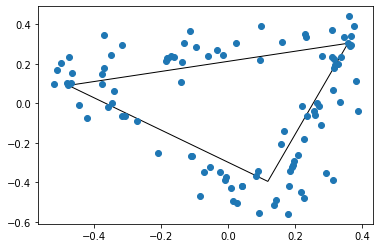

In [31]:
model_points, n_inliers, model = ransac_njit(points, triangle_model, 2, success_rate=0.9, p_inlier=0.2)
print(n_inliers)

vertices = model

plt.plot(points[:,0], points[:,1], "o")
plt.fill(vertices[:,0], vertices[:,1], fill=False)

plt.show()


In [192]:
@numba.njit
def sample_with_transform(vertices, n_points, max_angle=360, std=0.1, add_chance=1.0, sequential=False):
    points = np.empty((1,1))
    
    if sequential:
        points = sample_points_sequential(vertices, n_points)
    else:
        points = sample_points(vertices, n_points)

    angle = max_angle*np.random.rand(1)[0]
    points2 = rotate_points(points, angle)

    points3 = add_noise(points, 0.1, 1.0)

    return points3

In [56]:
tri_n_inliers_hist = np.empty(1000, int)

for i in range(1000):
    points = sample_with_transform(tri_points, 100, 120)
    points = scale_unit(points)

    model_points, n_inliers, model = ransac_njit(points, triangle_model, 2, success_rate=0.9, p_inlier=0.2)

    tri_n_inliers_hist[i] = n_inliers

In [34]:
np.mean(tri_n_inliers_hist)

NameError: name 'tri_n_inliers_hist' is not defined

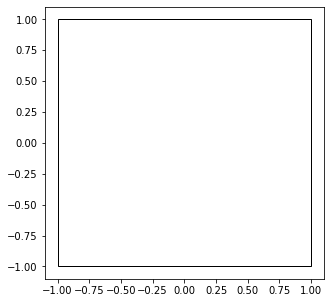

In [11]:
square_points = [[-1,1], [1,1], [1,-1], [-1,-1]]
square_points = np.array(square_points)

plt.figure(1, figsize=(5,5))
plt.fill(square_points[:,0], square_points[:,1], fill=False)
plt.show()

In [16]:
@numba.njit
def square_model2vertices(model_points, negative_direction):
    vertices = np.empty((4,2))
    vertices[:2] = model_points

    direction1 = np.zeros(3)
    direction1[:2] = model_points[1]-model_points[0]

    direction2 = np.cross(direction1, [0,0,1])

    direction2 = direction2[:2]
    direction2 /= np.linalg.norm(direction2)

    if negative_direction:
        direction2 *= -1

    side_len = np.linalg.norm(direction1)
    
    vertices[2] = model_points[1] + (side_len*direction2)
    vertices[3] = model_points[0] + (side_len*direction2)

    return vertices

@numba.njit
def square_model2vertices_p(model_points):
    return square_model2vertices(model_points, False)

@numba.njit
def square_model2vertices_n(model_points):
    return square_model2vertices(model_points, True)

square_inlier_distance = 0.1

@numba.njit
def square_model(points, model_points):
    n_inlier, vertices = polygon_model(points, model_points, square_model2vertices_p, square_inlier_distance)
    n_inlier_n, vertices_n = polygon_model(points, model_points, square_model2vertices_n, square_inlier_distance)

    if n_inlier > n_inlier_n:
        return n_inlier, vertices
    else:
        return n_inlier_n, vertices_n

In [45]:
square_n_inliers_hist = np.empty(1000, int)

for i in range(1000):
    points = sample_with_transform(square_points, 100, 90)
    points = scale_unit(points)

    model_points, n_inliers, vertices = ransac_njit(points, square_model, 2, success_rate=0.9, p_inlier=0.2)

    square_n_inliers_hist[i] = n_inliers

In [46]:
np.mean(square_n_inliers_hist)

96.508

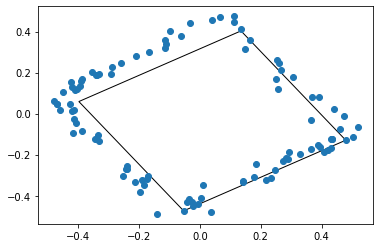

In [48]:
plt.plot(points[:,0], points[:,1], "o")
plt.fill(vertices[:,0], vertices[:,1], fill=False)

plt.show()

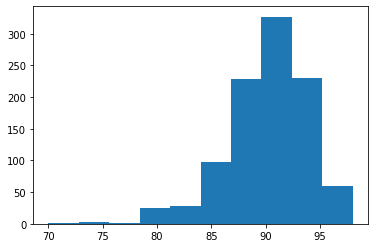

(array([  3.,  14.,  13.,  15.,  14.,  30.,  54.,  54., 207., 596.]),
 array([ 74. ,  76.6,  79.2,  81.8,  84.4,  87. ,  89.6,  92.2,  94.8,
         97.4, 100. ]),
 <BarContainer object of 10 artists>)

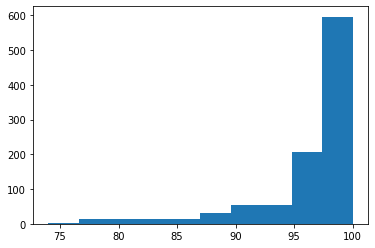

In [47]:
plt.hist(tri_n_inliers_hist)
plt.show()
plt.hist(square_n_inliers_hist)

In [133]:
inliers_hist = {}
inliers_hist["square"] = {"square":[], "triangle":[]}
inliers_hist["triangle"] = {"square":[], "triangle":[]}

triangle_inlier_distance = 0.1
@numba.njit
def triangle_model(points, model_points):
    global triangle_inlier_distance
    return polygon_model(points, model_points, triangle_model2vertices, triangle_inlier_distance)

for i in range(1000):
    points = sample_with_transform(square_points, 100, 90)
    points = scale_unit(points)

    model_points, n_inliers, vertices = ransac_njit(points, triangle_model, 2, success_rate=0.9, p_inlier=0.2)
    inliers_hist["square"]["triangle"].append(n_inliers)

    model_points, n_inliers, vertices = ransac_njit(points, square_model, 2, success_rate=0.9, p_inlier=0.2)
    inliers_hist["square"]["square"].append(n_inliers)

for i in range(1000):
    points = sample_with_transform(tri_points, 100, 120)
    points = scale_unit(points)

    model_points, n_inliers, vertices = ransac_njit(points, triangle_model, 2, success_rate=0.9, p_inlier=0.2)
    inliers_hist["triangle"]["triangle"].append(n_inliers)

    model_points, n_inliers, vertices = ransac_njit(points, square_model, 2, success_rate=0.9, p_inlier=0.2)
    inliers_hist["triangle"]["square"].append(n_inliers)

mean_inliers = {}
mean_inliers["square"] = {"square":0, "triangle":0}
mean_inliers["triangle"] = {"square":0, "triangle":0}

for key in mean_inliers:
    for key2 in mean_inliers[key]:
        mean_inliers[key][key2] = np.mean(inliers_hist[key][key2])

mean_inliers

{'square': {'square': 96.169, 'triangle': 61.245},
 'triangle': {'square': 86.656, 'triangle': 90.023}}

# Angle

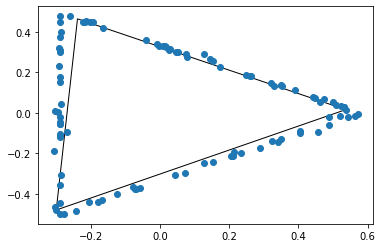

In [ ]:
points = sample_points(tri_points, 100)
points = rotate_points(points, 90)
points = add_noise(points, 0.01, 1.0)

model_points, n_inliers, model = ransac_njit(points, triangle_model, 2, success_rate=0.9, p_inlier=0.2)

vertices = triangle_model2vertices(model_points)

plt.plot(points[:,0], points[:,1], "o")
plt.fill(vertices[:,0], vertices[:,1], fill=False)
plt.show()

$ A_i = R B_i$\
$A_i$: sample vertices\
$B_i$: reference triangle vertices

In [ ]:
vertices

array([[ 0.53645188,  0.01576866],
       [-0.29888572, -0.47924298],
       [-0.23756616,  0.46347432]])

In [ ]:
rotate_points(tri_points, 90)

array([[-0.28867513,  0.5       ],
       [-0.28867513, -0.5       ],
       [ 0.57735027,  0.        ]])

In [ ]:
B = np.zeros((3,3))
A = np.zeros((3,3))

B[:, :2] = vertices* 10
A[:, :2] = tri_points

B = B.T
A = A.T

X = B@A.T

u, s, v_t = np.linalg.svd(X)

scale = np.eye(3)
scale[2,2] = np.linalg.det(u@v_t)

R = v_t.T@scale@u.T

Rotation.from_matrix(R).as_euler("xyz", degrees=True)

array([ 180.        ,    0.        , -151.04080896])

In [ ]:
s

array([4.90462598, 4.45631461, 0.        ])

In [ ]:
Rotation.from_euler("xyz", [0, 0, 90] , degrees=True).as_matrix()

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [ ]:
Rotation.from_matrix(R).as_euler("xyz", degrees=True)

array([ 180.        ,    0.        , -151.04080896])

In [ ]:
Rotation.from_matrix(R).as_euler("xyz", degrees=True)+360-120

array([420.        , 240.        ,  88.95919104])

# Unity test

In [28]:
df_triangle = pd.read_csv("Points_Triangle.csv", sep=";", decimal=",", names=["x", "y"])
df_square = pd.read_csv("Points_Square.csv", sep=";", decimal=",", names=["x", "y"])

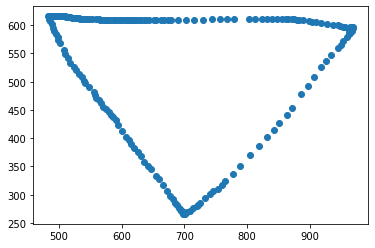

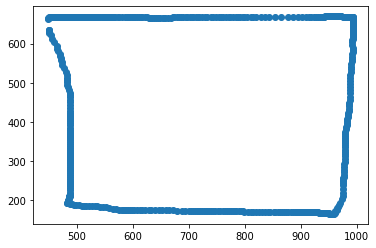

In [29]:
all_points_tr = df_triangle.to_numpy()
all_points_sq = df_square.to_numpy()

plt.plot(all_points_tr[:,0], all_points_tr[:,1], "o")
plt.show()

plt.plot(all_points_sq[:,0], all_points_sq[:,1], "o")
plt.show()

In [21]:
def sample_points_fromlist(points:np.ndarray, n_point:int) -> np.ndarray:
    indexs = np.random.choice(points.shape[0], size=n_point, replace=False)
    
    return points[indexs]

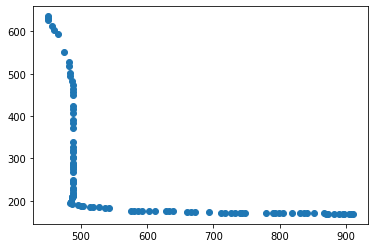

In [130]:
points = sample_points_fromlist(all_points_sq[:200], 100)

plt.plot(points[:,0], points[:,1], "o")
plt.show()

In [132]:
points_scaled = scale_unit(points)

model_points, n_inliers, vertices = ransac_njit(points_scaled, triangle_model, 2, success_rate=0.9, p_inlier=0.2)

n_inliers

68

# NN

In [202]:
@numba.njit
def center_points(points):
    center = np.array([points[:,0].mean(), points[:,1].mean()])
    return points.copy()-center

In [ ]:
samples_per_type = 50000

In [212]:

@numba.njit
def create_features(samples_per_type, std_min, std_max):
    features = np.empty((samples_per_type*3, 200))
    index = 0

    for i in range(50000):
        std = np.random.uniform(std_min, std_max, 1)[0]
        add_chance = np.random.uniform(0.5, 1.0, 1)[0]

        points = sample_with_transform(square_points, 100, 90, std, add_chance, True)
        points = center_points(points)
        points = scale_unit(points)

        features[index] = points.flatten()
        index += 1

    for i in range(50000):
        std = np.random.uniform(std_min, std_max, 1)[0]
        add_chance = np.random.uniform(0.5, 1.0, 1)[0]

        points = sample_with_transform(tri_points, 100, 120, std, add_chance, True)
        points = center_points(points)
        points = scale_unit(points)

        features[index] = points.flatten()
        index += 1

    for i in range(50000):
        points = np.random.rand(100,2)
        points = center_points(points)
        points = scale_unit(points)

        features[index] = points.flatten()
        index += 1

    return features



In [213]:
create_features(10, 1e-3, 1e-1)

: 

: 

In [106]:
targets = np.empty(3*samples_per_type, int)
targets[:1*samples_per_type] = 0
targets[1*samples_per_type:2*samples_per_type] = 1
targets[2*samples_per_type:] = 2

In [109]:
total_samples = 3*samples_per_type

In [18]:
import tensorflow as tf
from tensorflow import keras

In [20]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eltoncn. Use `wandb login --relogin` to force relogin


True

In [110]:
indexes = np.random.choice(total_samples, size=total_samples, replace=False)

train_features = features[indexes[:int(0.7*total_samples)]]
train_targets = targets[indexes[:int(0.7*total_samples)]]

val_features = features[indexes[int(0.7*total_samples):int(0.9*total_samples)]]
val_targets = targets[indexes[int(0.7*total_samples):int(0.9*total_samples)]]

test_features = features[indexes[int(0.9*total_samples):]]
test_targets = targets[indexes[int(0.9*total_samples):]]

In [111]:
data = {
"train_features": train_features,
"train_targets": train_targets,
"val_features": val_features,
"val_targets": val_targets,
"test_features": test_features,
"test_targets": test_targets,
}

In [112]:
np.save("data3.npy", data)

In [113]:
data = np.load("data3.npy", allow_pickle=True).item()
train_features = data["train_features"]
train_targets = data["train_targets"]
val_features = data["val_features"]
val_targets = data["val_targets"]
test_features = data["test_features"]
test_targets = data["test_targets"]

In [114]:
n_features = 100*2

n_train = train_features.shape[0]

In [115]:
from tensorflow.keras.regularizers import l2

array([[     1],
       [     3],
       [     4],
       ...,
       [104986],
       [104991],
       [104995]], dtype=int64)

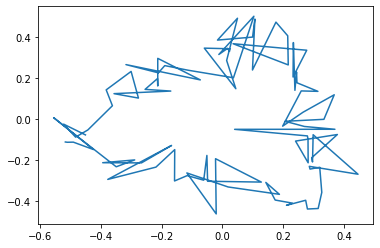

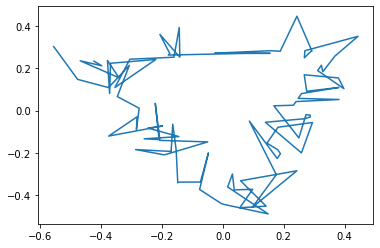

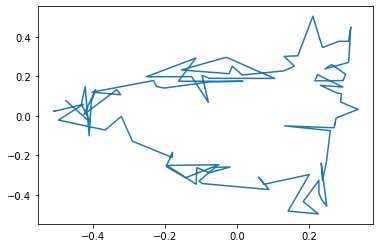

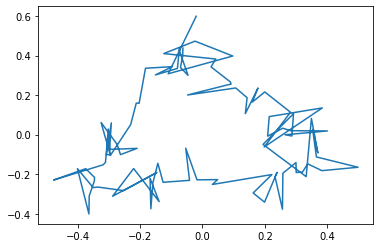

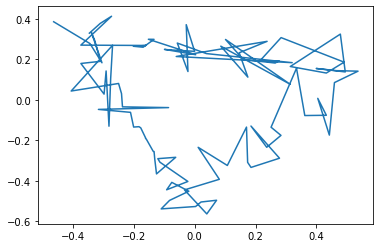

In [127]:
indexes = np.argwhere(train_targets == 1)

for i in range(5):

    a = train_features[indexes[i]].reshape((100,2))
    plt.plot(a[:,0], a[:,1])
    plt.show()

In [116]:
def compile_fit(model, epochs, optimizer, batch_size, patience, units, regularizer, others=""):
    learning_rate = optimizer.learning_rate.numpy()
    
    config = {}
    config["leaning_rate"] = learning_rate
    config["epochs"] = epochs
    config["batch_size"] = batch_size
    config["optimizer"] = optimizer._name
    config["others"] = others

    config["layer0_units"] = units[0]
    config["layer0_l2"] = regularizer[0]

    if len(units) > 1:
        config["layer1_units"] = units[1]
        config["layer1_l2"] = regularizer[1]
    else:
        config["layer1_units"] = 0
        config["layer1_l2"] = 0

    run = wandb.init(project="SygilDetector", config = config)


    callbacks = []
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_crossentropy", patience=patience))
    callbacks.append(WandbCallback("val_sparse_categorical_crossentropy"))

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy", "accuracy"])

    hist = model.fit(train_features, train_targets, validation_data=(val_features, val_targets), epochs=epochs, batch_size=batch_size,
                callbacks=callbacks)

    wandb.finish()
    
    return hist


In [46]:
units = [400, 400]
regularizer = [0.0075, 0.0075]

model = keras.Sequential([keras.layers.Input(shape=(n_features), name="input"),
                    keras.layers.Dense(units[0], activation="relu", kernel_regularizer=l2(regularizer[0])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(units[1], activation="relu", kernel_regularizer=l2(regularizer[1])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(3, activation="softmax")])

optimizer = keras.optimizers.Adam(learning_rate=0.001)#(learning_rate=0.0005)
#optimizer = keras.optimizers.SGD(learning_rate=0.02)

compile_fit(model, 1000, optimizer, 10000//2, 50, units, regularizer, "dropout[0.5, 0.5]")


Epoch 1/1000
21/21 [==============================] - 1s 20ms/step - loss: 4.7695 - sparse_categorical_crossentropy: 1.1104 - accuracy: 0.3373 - val_loss: 3.5052 - val_sparse_categorical_crossentropy: 1.0901 - val_accuracy: 0.3459
Epoch 2/1000
21/21 [==============================] - 0s 9ms/step - loss: 2.7607 - sparse_categorical_crossentropy: 1.0875 - accuracy: 0.3824 - val_loss: 2.1131 - val_sparse_categorical_crossentropy: 1.0798 - val_accuracy: 0.5075
Epoch 3/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.7666 - sparse_categorical_crossentropy: 1.0716 - accuracy: 0.4726 - val_loss: 1.4751 - val_sparse_categorical_crossentropy: 1.0584 - val_accuracy: 0.5967
Epoch 4/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.3360 - sparse_categorical_crossentropy: 1.0533 - accuracy: 0.5206 - val_loss: 1.2244 - val_sparse_categorical_crossentropy: 1.0472 - val_accuracy: 0.5968
Epoch 5/1000
21/21 [==============================] - 0s 11ms/step - loss: 1.1

accuracy,▁▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_crossentropy,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▅▆▆▇▇▆██▇▇█▇▇▇▇██▇█▇▇█▇█▇██████▇▇▆███▇
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_sparse_categorical_crossentropy,█▇▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
GFLOPS,0.00024
accuracy,0.70833
best_epoch,214
best_val_sparse_categorical_crossentropy,0.70844


In [55]:
points_sq = sample_points_fromlist(all_points_sq, 100)
points_tr = sample_points_fromlist(all_points_tr, 100)

points_sq = center_points(points_sq)
points_tr = center_points(points_tr)

points_sq = scale_unit(points_sq)
points_tr = scale_unit(points_tr)

result = model(np.array([points_sq.flatten(), points_tr.flatten()]))


In [56]:
np.argmax(result.numpy(), axis=1)

array([0, 1], dtype=int64)

In [83]:
import tf2onnx

onnx_model = tf2onnx.convert.from_keras(model)

In [ ]:
tf2onnx.utils.save_onnx_model(".", "sygil_detector.onnx")

In [85]:
with open(os.path.join("sygil_detector.onnx"), "wb") as f:
    f.write(onnx_model[0].SerializeToString())

In [86]:
model.save("models")

INFO:tensorflow:Assets written to: models\assets


In [22]:
model = keras.models.load_model("models")

## Unity test

In [46]:
df_triangle = pd.read_csv("Points_Triangle2.csv", sep=";", decimal=",", names=["x", "y"])
all_points_tr = df_triangle.to_numpy()



In [47]:
points = sample_points_fromlist(all_points_tr, 100)
points = center_points(points)
points = scale_unit(points)

In [50]:
model(np.array([points.flatten()]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.01719803, 0.8988198 , 0.08398208]], dtype=float32)>

In [30]:
points = sample_points_fromlist(all_points_sq, 100)
points = center_points(points)
points = scale_unit(points)

In [32]:
model(np.array([points.flatten()])).numpy()

array([[9.5850545e-01, 3.9079445e-08, 4.1494541e-02]], dtype=float32)

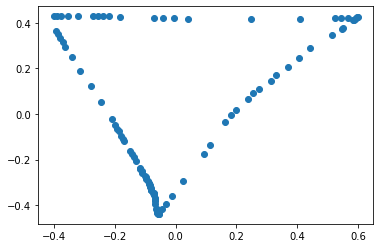

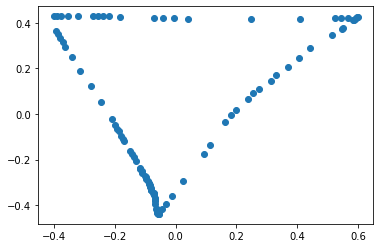

array([[7.3972428e-01, 2.5870226e-04, 2.6001698e-01]], dtype=float32)

In [58]:
df = pd.read_csv("input.csv", sep=";", decimal=",", names=["x", "y"])
points = df.to_numpy()[100:]

plt.plot(points[:,0], points[:,1], "o")
plt.show()

points = center_points(points)
points = scale_unit(points)

plt.plot(points[:,0], points[:,1], "o")
plt.show()


model(np.array([points.flatten()])).numpy()

In [60]:
model(np.array([points.flatten()/2])).numpy()

array([[0.00111005, 0.99008113, 0.00880879]], dtype=float32)

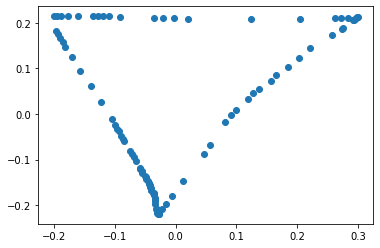

In [59]:
plt.plot(points[:,0]/2, points[:,1]/2, "o")
plt.show()

In [61]:
def sample_points_fromlist_sequential(points:np.ndarray, n_point:int) -> np.ndarray:
    indexs = np.random.choice(points.shape[0], size=n_point, replace=False)

    indexs = np.sort(indexs)
    
    return points[indexs]

In [64]:
points = sample_points_fromlist_sequential(all_points_tr, 100)
points = center_points(points)
points = scale_unit(points)

model(np.array([points.flatten()])).numpy()

array([[0.00282414, 0.9776854 , 0.01949057]], dtype=float32)

# EP

In [6]:
import evolvepy as ep


def create_generator(model):
    first = ep.generator.Layer()
    combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
    mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.5, (-0.5, 0.5))
    filter0 = ep.generator.FilterFirsts(143)
    sort = ep.generator.Sort()
    filter1 = ep.generator.FilterFirsts(7)
    concat = ep.generator.Concatenate()

    first.next = combine
    combine.next = mutation
    combine.next = filter0
    filter0.next = concat

    first.next = sort
    sort.next = filter1
    filter1.next = concat

    #Creates the generator using the descriptor.
    generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=model.descriptor)

    return generator, mutation.name

In [315]:
import importlib
importlib.reload(ep)

<module 'evolvepy' from 'D:\\Github\\evolvepy\\src\\evolvepy\\__init__.py'>

In [12]:
def compile_fit_ep(model, epochs, generator, batch_size, patience, units, regularizer, others=""):
    
    config = {}
    config["epochs"] = epochs
    config["batch_size"] = batch_size
    config["optimizer"] = "evolutionary"
    config["others"] = others

    config["layer0_units"] = units[0]
    config["layer0_l2"] = regularizer[0]

    if len(units) > 1:
        config["layer1_units"] = units[1]
        config["layer1_l2"] = regularizer[1]
    else:
        config["layer1_units"] = 0
        config["layer1_l2"] = 0

    run = wandb.init(project="SygilDetector", config = config)

    callbacks = []
    #callbacks.append(keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_crossentropy", patience=patience))
    callbacks.append(WandbCallback("val_sparse_categorical_crossentropy"))

    model.compile(generator, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy", "accuracy"])

    hist = model.fit(train_features, train_targets, validation_data=(val_features, val_targets), epochs=epochs, batch_size=batch_size,
                callbacks=callbacks)

    wandb.finish()
    
    return hist

In [13]:
from evolvepy.integrations.tf_keras import EvolutionaryModel

units = [400, 400]
regularizer = [0, 0]

model = EvolutionaryModel([keras.layers.Input(shape=(n_features), name="input"),
                    keras.layers.Dense(units[0], activation="relu"),
                    keras.layers.Dense(units[1], activation="relu"),
                    keras.layers.Dense(3, activation="softmax")])
                    
generator, _ = create_generator(model)

model.compile(generator, 150, loss="sparse_categorical_crossentropy",  metrics=["sparse_categorical_crossentropy", "accuracy"])

hist = compile_fit_ep(model, 400, generator, 10000, 50, units, regularizer)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/400
3/3 [==============================] - 8s 3s/step - loss: 78.6250 - sparse_categorical_crossentropy: 79.9023 - accuracy: 0.3450 - val_loss: 81.3198 - val_sparse_categorical_crossentropy: 81.3198 - val_accuracy: 0.3320
Epoch 2/400
3/3 [==============================] - 5s 1s/step - loss: 78.8996 - sparse_categorical_crossentropy: 79.9023 - accuracy: 0.3450 - val_loss: 81.3198 - val_sparse_categorical_crossentropy: 81.3198 - val_accuracy: 0.3320
Epoch 3/400
3/3 [==============================] - 5s 1s/step - loss: 81.8312 - sparse_categorical_crossentropy: 79.9023 - accuracy: 0.3450 - val_loss: 81.3198 - val_sparse_categorical_crossentropy: 81.3198 - val_accuracy: 0.3320
Epoch 4/400
3/3 [==============================] - 4s 1s/step - loss: 82.0725 - sparse_categorical_crossentropy: 79.9023 - accuracy: 0.3450 - val_loss: 81.3198 - val_sparse_categorical_crossentropy: 81.3198 - val_accuracy

accuracy,▄▁▅▅████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▃▁▂▂▂▂▂▁▂▁▃▂▁▂▂▂▂▁▂▂▂▂▁▂▁▂▂▃▁▁▂▂▂▂▃▃▁
sparse_categorical_crossentropy,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆█▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
val_loss,█▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_crossentropy,█▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00024
accuracy,0.35438
best_epoch,55
best_val_sparse_categorical_crossentropy,56.67062
